In [1]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
import opendatasets as od
import os
import albumentations as A

In [3]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler

In [4]:
od.download('https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri')

Skipping, found downloaded files in ".\brain-tumor-classification-mri" (use force=True to force download)


In [5]:
dataset_path = "brain-tumor-classification-mri/Training"

In [6]:
testset_path = "brain-tumor-classification-mri/Testing"

In [7]:
classes = sorted(os.listdir(dataset_path))

In [8]:
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [9]:
IMAGE_SIZE = 244

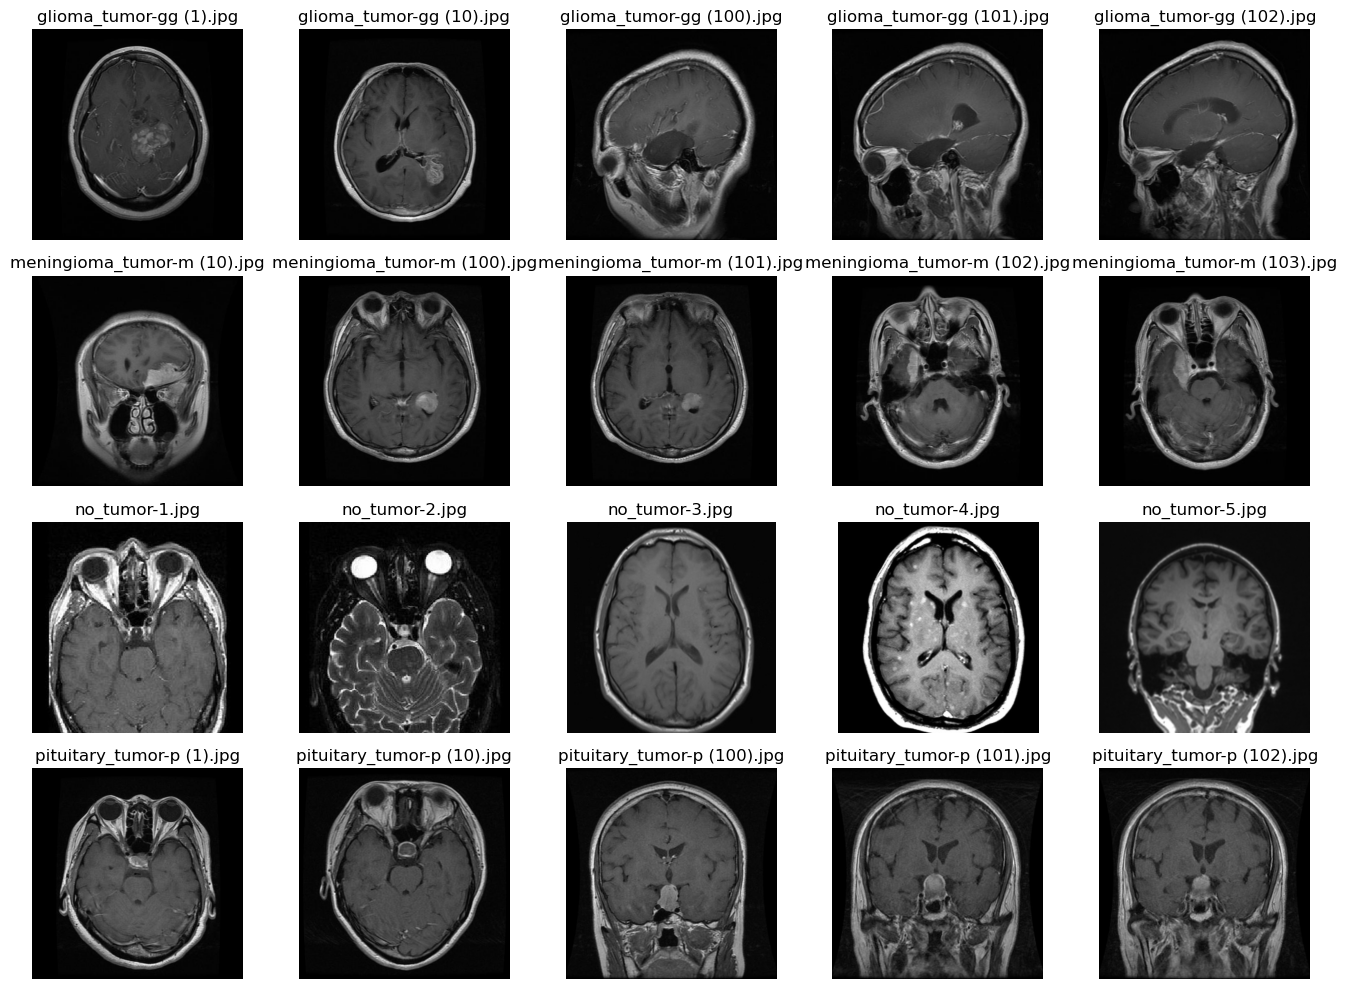

In [10]:
from PIL import Image
base_path = dataset_path
plt.figure(figsize=(15, 10))
image_count = 1

for label in classes:
    label_path = os.path.join(dataset_path, label)
    images = os.listdir(label_path)[:5]  # Get the first 5 images from the class
    # print(images)
    for img_name in images:
        img_path = os.path.join(label_path, img_name)
        img = Image.open(img_path)
        img_array = np.asarray(img)

        plt.subplot(len(classes), 5, image_count)
        plt.imshow(img_array)
        plt.title(f"{label}-{img_name}")
        plt.axis("off")
        plt.tight_layout()
        image_count += 1

plt.tight_layout()
plt.show()


In [11]:
#for the training dataset
X_data = []
y_data = []

for label in classes:
  folder = os.path.join(dataset_path, label)
  for image_name in os.listdir(folder):
    image_path = os.path.join(folder, image_name)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    X_data.append(image)
    y_data.append(label)


In [12]:
X_test = []
y_test = []

In [13]:
#for the testing dataset

for label in classes:
  folder = os.path.join(testset_path, label)
  for image_name in os.listdir(folder):
    image_path = os.path.join(folder, image_name)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    X_test.append(image)
    y_test.append(label)

In [14]:
X_data = np.array(X_data)
y_data = np.array(y_data)

In [15]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
print(X_data.shape)
print(X_test.shape)

(2870, 244, 244, 3)
(394, 244, 244, 3)


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42)

In [18]:
print("train:", X_train.shape)
print("val:", X_val.shape)
print("test:", X_test.shape)

train: (2583, 244, 244, 3)
val: (287, 244, 244, 3)
test: (394, 244, 244, 3)


In [19]:
X_train = X_train.reshape(-1, 244*244*3)

In [20]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [21]:
# plt.subplot(2,1,1)
# sns.countplot(y_train)

# plt.subplot(2,1,2)
# sns.countplot(y_smote)

In [22]:
X_train = X_smote.reshape(-1, 244, 244, 3)

In [23]:
X_train.shape

(3004, 244, 244, 3)

In [24]:
y_train = y_smote

In [25]:
y_train.shape

(3004,)

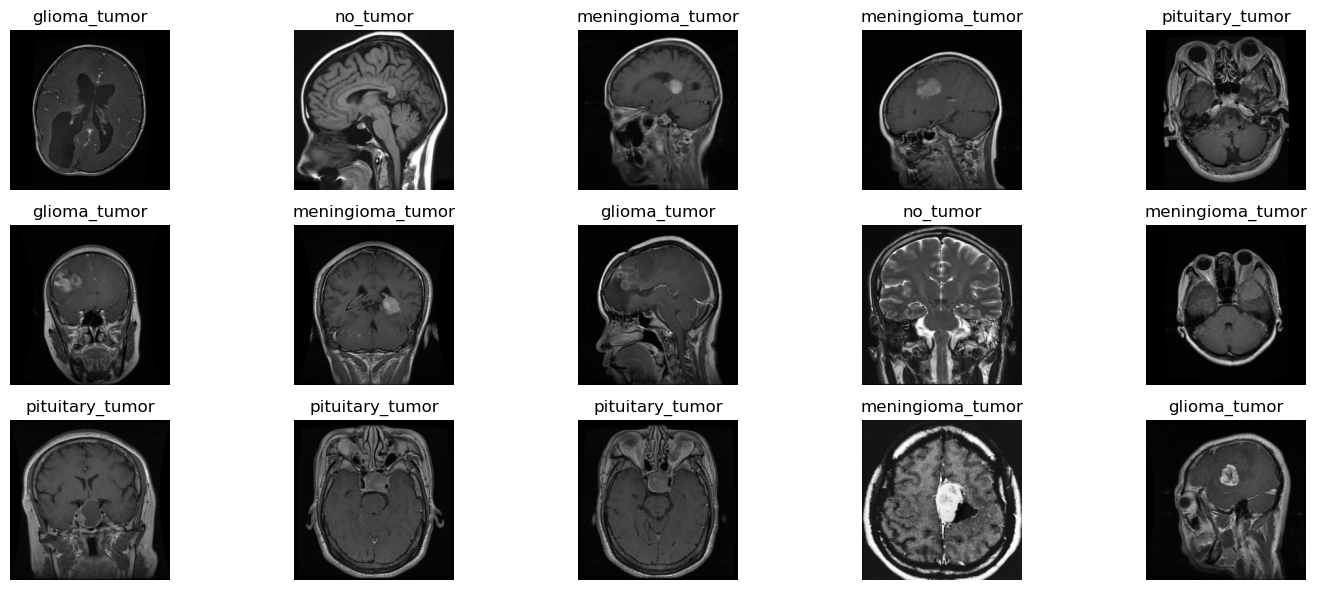

In [26]:
#plot data samples from different categories
plt.figure(figsize=(15, 6))

for i in range(1, 16):
    plt.subplot(3, 5, i)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [27]:
class_counts = pd.Series(y_train).value_counts()
print("Number of samples in each category:")
print(class_counts)

Number of samples in each category:
meningioma_tumor    751
glioma_tumor        751
no_tumor            751
pituitary_tumor     751
Name: count, dtype: int64


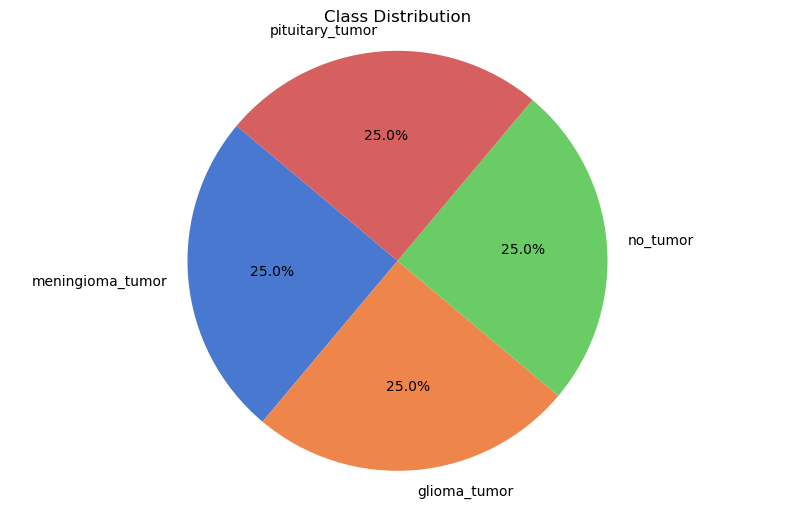

In [28]:
plt.figure(figsize=(10, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("muted"))
plt.title("Class Distribution")
plt.axis('equal')
plt.show()

In [29]:
y_train_one_hot = [classes.index(label) for label in y_train]
y_train = tf.keras.utils.to_categorical(y_train_one_hot, num_classes=len(classes))

y_val_one_hot = [classes.index(label) for label in y_val]
y_val = tf.keras.utils.to_categorical(y_val_one_hot, num_classes=len(classes))

In [30]:
# def mixup(data1, data2):
#     image_1, label_1 = data1
#     image_2, label_2 = data2

#     label_1 = tf.cast(label_1, dtype=tf.float32)
#     label_2 = tf.cast(label_2, dtype=tf.float32)

#     lamda = np.random.beta(0.2, 0.2, size=1)[0]
#     mixed_image = lamda * image_1 + (1 - lamda) * image_2
#     mixed_label = lamda * label_1 + (1 - lamda) * label_2

#     return mixed_image, mixed_label

def mixup(data1, data2):
    image_1, label_1 = data1
    image_2, label_2 = data2
    
    # # Ensure all tensors are float32
    # image_1 = tf.cast(image_1, tf.float32)
    # image_2 = tf.cast(image_2, tf.float32)
    # label_1 = tf.cast(label_1, tf.float32)
    # label_2 = tf.cast(label_2, tf.float32)
    
    # Beta distribution sampling (α=β=0.2 for strong mixing)
    lamda = tf.random.uniform([], 0, 1, dtype=tf.float32)  # Simple uniform
    # OR for true Beta mixing:
    # lamda = tfp.distributions.Beta(0.2, 0.2).sample(1)[0]
    
    mixed_image = lamda * image_1 + (1 - lamda) * image_2
    mixed_label = lamda * label_1 + (1 - lamda) * label_2
    
    return mixed_image, mixed_label

In [31]:
mixup_data = np.copy(X_train)
mixup_y = np.copy(y_train)

In [32]:
X_use, X_remove, y_use, y_remove = train_test_split(mixup_data, mixup_y, test_size=0.1, random_state=42)

In [33]:
X_use_temp = np.copy(X_use)
y_use_temp = np.copy(y_use)
X_use2, y_use2 = shuffle(X_use_temp, y_use_temp, random_state=42)

In [34]:
Mixup_augmented_X_train = []
Mixup_augmented_y_train = []

In [35]:
for i, image in enumerate(X_use):
    mixed_image, mixed_label = mixup((image, y_use[i]), (X_use2[i], y_use2[i]))
    Mixup_augmented_X_train.append(mixed_image)
    Mixup_augmented_y_train.append(mixed_label)

In [36]:
Mixup_augmented_X_train = np.array(Mixup_augmented_X_train)
Mixup_augmented_X_train.shape

(2703, 244, 244, 3)

In [37]:
Mixup_augmented_y_train = np.array(Mixup_augmented_y_train)
Mixup_augmented_y_train.shape

(2703, 4)

In [38]:
mean_original = X_train.mean()
mean_original

50.74755701190851

In [39]:
mean_augmented = Mixup_augmented_X_train.mean()
mean_augmented

50.596775

In [40]:
X_combined = np.concatenate((X_train, Mixup_augmented_X_train), axis=0)
y_combined = np.concatenate((y_train, Mixup_augmented_y_train), axis=0)

In [41]:
X_train, y_train = shuffle(X_combined, y_combined, random_state=42)

In [42]:
X_train.shape

(5707, 244, 244, 3)

In [43]:
y_train.shape

(5707, 4)

In [44]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [45]:
es_callback = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='max',
    baseline=None,
    restore_best_weights=True  # Restore the weights of the best epoch
)

In [46]:
def scheduler(epoch, lr):

  if epoch <= 5:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.01)
    learning_rate = learning_rate.numpy()

  return learning_rate

scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

In [47]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3, 3),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3, 3),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [48]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [49]:
print("X_train:", X_train.shape, X_train.dtype, "min/max:", X_train.min(), X_train.max())
print("y_train:", y_train.shape, y_train.dtype, "min/max:", y_train.min(), y_train.max())
print("X_val:", X_val.shape, X_val.dtype, "min/max:", X_val.min(), X_val.max())
print("y_val:", y_val.shape, y_val.dtype, "min/max:", y_val.min(), y_val.max())

X_train: (5707, 244, 244, 3) float32 min/max: 0.0 1.0
y_train: (5707, 4) float64 min/max: 0.0 1.0
X_val: (287, 244, 244, 3) float64 min/max: 0.0 1.0
y_val: (287, 4) float64 min/max: 0.0 1.0


In [50]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks = [scheduler_callback, es_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 187s 966ms/step - accuracy: 0.3557 - loss: 1.5808 - val_accuracy: 0.2927 - val_loss: 2.0055 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 166s 927ms/step - accuracy: 0.4802 - loss: 1.2557 - val_accuracy: 0.2927 - val_loss: 1.8634 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 167s 935ms/step - accuracy: 0.5732 - loss: 1.0982 - val_accuracy: 0.4599 - val_loss: 1.2515 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 176s 981ms/step - accuracy: 0.6022 - loss: 1.0210 - val_accuracy: 0.5819 - val_loss: 1.0012 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to

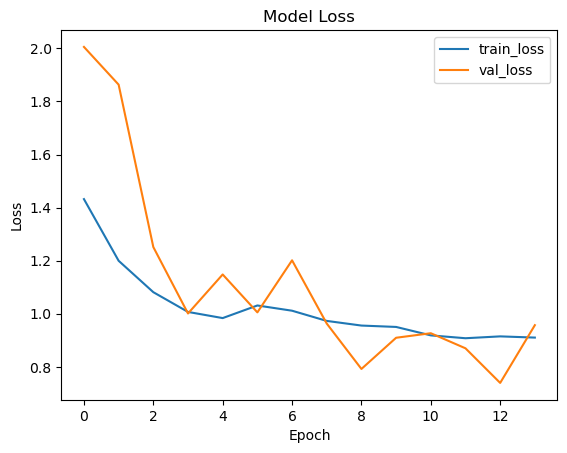

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

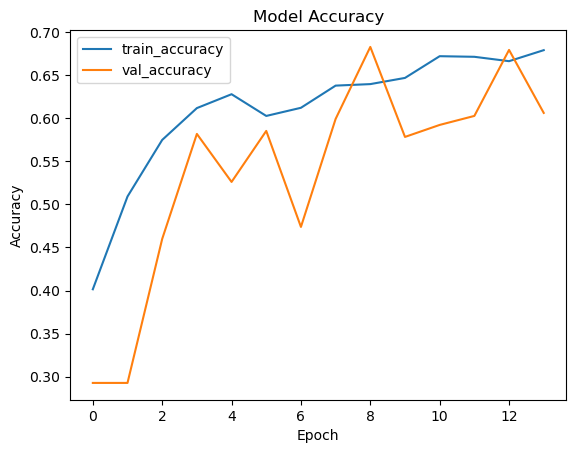

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])